In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import VOCSegmentation
from torch.utils.data import DataLoader, random_split
import torchvision.models as models
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.metrics import jaccard_score, f1_score, accuracy_score
import time

In [4]:
class SegNetVGG(nn.Module):
    def __init__(self, num_classes=21):
        super(SegNetVGG, self).__init__()
        vgg16_bn = models.vgg16_bn(weights=models.VGG16_BN_Weights.DEFAULT)  # Updated weights loading
        features = list(vgg16_bn.features.children())

        # Encoder: Store max-pooling indices for unpooling in decoder
        self.encoder = nn.ModuleList([
            nn.Sequential(*features[0:6]),   # Conv1 (64)
            nn.Sequential(*features[7:13]),  # Conv2 (128)
            nn.Sequential(*features[14:23]), # Conv3 (256)
            nn.Sequential(*features[24:33]), # Conv4 (512)
            nn.Sequential(*features[34:43])  # Conv5 (512)
        ])

        # Freeze encoder weights (pre-trained on ImageNet)
        # for param in self.encoder.parameters():
        #     param.requires_grad = False

        # Decoder: Modified to ensure correct output size
        self.decoder = nn.ModuleList([
            self._decoder_block(512, 512),  # Deconv5
            self._decoder_block(512, 256),  # Deconv4
            self._decoder_block(256, 128),  # Deconv3
            self._decoder_block(128, 64),   # Deconv2
            self._decoder_block(64, 64)     # Deconv1
        ])

        # Final upsampling layer to ensure output matches input size
        self.upsample_final = nn.ConvTranspose2d(64, 64, kernel_size=3, stride=2, padding=1, output_padding=1)

        # Final classification layer
        self.final_layer = nn.Conv2d(64, num_classes, kernel_size=1)

    def _decoder_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(in_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        indices = []
        sizes = []

        # Encoder forward pass with max pooling index storage
        for enc_layer in self.encoder:
            sizes.append(x.size())
            x = enc_layer(x)
            x, idx = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)(x)
            indices.append(idx)

        # Decoder forward pass with unpooling
        for dec_layer, idx, size in zip(self.decoder, reversed(indices), reversed(sizes)):
            x = nn.MaxUnpool2d(kernel_size=2, stride=2)(x, idx, output_size=size)
            x = dec_layer(x)

        # Additional upsampling to ensure final size matches ground truth masks (256x256)
        # x = self.upsample_final(x)

        # Final classification layer
        x = self.final_layer(x)
        return x

In [19]:
class SegNetEfficientNet(nn.Module):
    def __init__(self, num_classes=21):
        super(SegNetEfficientNet, self).__init__()

        # Load EfficientNet as Encoder
        efficientnet = models.efficientnet_b0(pretrained=True)
        encoder_layers = list(efficientnet.features.children())

        # Encoder Layers (Matching Output Shapes)
        self.enc1 = encoder_layers[0]  # [4, 32, 128, 128]
        self.enc2 = encoder_layers[1]  # [4, 16, 128, 128]
        self.enc3 = encoder_layers[2]  # [4, 24, 64, 64]
        self.enc4 = encoder_layers[3]  # [4, 40, 32, 32]
        self.enc5 = encoder_layers[4]  # [4, 80, 16, 16]
        self.enc6 = encoder_layers[5]  # [4, 112, 16, 16]
        self.enc7 = encoder_layers[6]  # [4, 192, 8, 8]
        self.enc8 = encoder_layers[7]  # [4, 320, 8, 8]
        self.enc9 = nn.Conv2d(320, 1280, kernel_size=1)  # Bottleneck

        # Decoder Layers (With Matching Sizes)
        self.dec1 = self.decoder_block(1280, 320)  # [4, 320, 8, 8]
        self.dec2 = self.decoder_block(320 + 192, 112)  # [4, 112, 16, 16]
        self.dec3 = self.decoder_block(112 + 80, 40)  # [4, 40, 16, 16]
        self.dec4 = self.decoder_block(40 + 40, 24)  # [4, 24, 32, 32]
        self.dec5 = self.decoder_block(24 + 24, 16)  # [4, 16, 64, 64]
        self.dec6 = self.decoder_block(16 + 16, 32)  # [4, 32, 128, 128]
        self.dec7 = self.decoder_block(32 + 32, num_classes)  # [4, num_classes, 128, 128]

        # Final Upsampling Layer (128x128 → 256x256)
        self.final_upsample = nn.ConvTranspose2d(num_classes, num_classes, kernel_size=4, stride=2, padding=1)

    def decoder_block(self, in_channels, out_channels):
        """Decoder block with Conv and Upsampling"""
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        # [batch_size, 3, 256, 256]

        # **Encoder Forward Pass**
        x1 = self.enc1(x)   # [4, 32, 128, 128]

        x2 = self.enc2(x1)  # [4, 16, 128, 128]

        x3 = self.enc3(x2)  # [4, 24, 64, 64]

        x4 = self.enc4(x3)  # [4, 40, 32, 32]

        x5 = self.enc5(x4)  # [4, 80, 16, 16]

        x6 = self.enc6(x5)  # [4, 112, 16, 16]

        x7 = self.enc7(x6)  # [4, 192, 8, 8]

        x8 = self.enc8(x7)  # [4, 320, 8, 8]

        x9 = self.enc9(x8)

        # **Decoder Forward Pass with Skip Connections**
        d1 = self.dec1(x9)  # [4, 320, 8, 8]
        d1 = F.interpolate(d1, size=x8.shape[2:], mode="bilinear", align_corners=False)

        d2 = self.dec2(torch.cat([d1, x7], dim=1))  # [4, 112, 16, 16]
        d2 = F.interpolate(d2, size=x6.shape[2:], mode="bilinear", align_corners=False)

        d3 = self.dec3(torch.cat([d2, x5], dim=1))  # [4, 40, 16, 16]
        d3 = F.interpolate(d3, size=x4.shape[2:], mode="bilinear", align_corners=False)

        d4 = self.dec4(torch.cat([d3, x4], dim=1))  # [4, 24, 32, 32]
        d4 = F.interpolate(d4, size=x3.shape[2:], mode="bilinear", align_corners=False)

        d5 = self.dec5(torch.cat([d4, x3], dim=1))  # [4, 16, 64, 64]
        d5 = F.interpolate(d5, size=x2.shape[2:], mode="bilinear", align_corners=False)

        d6 = self.dec6(torch.cat([d5, x2], dim=1))  # [4, 32, 128, 128]
        d6 = F.interpolate(d6, size=x1.shape[2:], mode="bilinear", align_corners=False)

        d7 = self.dec7(torch.cat([d6, x1], dim=1))  # [4, num_classes, 128, 128]

        # **Final Upsampling to 256x256**
        output = self.final_upsample(d7)  # [4, num_classes, 256, 256]

        return output

In [7]:
def get_dataloader(batch_size=4, val_split=0.2, type_of_data='train'):
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor()
    ])
    # Define a transform for the mask specifically to ensure correct format
    class VOCSegmentationWithTransforms(VOCSegmentation):
        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)

        def __getitem__(self, index):
            img, target = super().__getitem__(index)
            # Apply the same transformation to the image and target (mask)
            img = transform(img)
            target = transform(target)  # Ensure the mask is transformed to tensor as well
            return img, target

    if type_of_data == 'train':
        dataset = VOCSegmentationWithTransforms(root='./data', year='2012', image_set='train', download=True)

        train_size = int((1 - val_split) * len(dataset))
        val_size = len(dataset) - train_size

        train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        return train_loader, val_loader

    elif type_of_data == 'test':
        dataset = VOCSegmentationWithTransforms(root='./data', year='2012', image_set='val', download=True)
        test_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

        return test_loader

In [30]:
def train_model(model, train_loader, val_loader, epochs=10, lr=0.001, patience=3):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    criterion = nn.CrossEntropyLoss()  # Suitable for multi-class segmentation
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)

    best_val_loss = float('inf')
    patience_counter = 0
    train_losses, val_losses = [], []

    start_time = time.time()

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for images, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Training]"):
            images, masks = images.to(device, non_blocking=True), masks.to(device, non_blocking=True)

            optimizer.zero_grad()
            outputs = model(images)  # Output shape: (batch_size, num_classes, H, W)

            # Ensure masks are of type long and correct shape for CrossEntropyLoss
            masks = masks.squeeze(1).long()  # Shape: (batch_size, H, W)
            # print(masks.shape)
            # print(outputs.shape)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, masks in tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Validation]"):
                images, masks = images.to(device, non_blocking=True), masks.to(device, non_blocking=True)

                outputs = model(images)
                masks = masks.squeeze(1).long()

                loss = criterion(outputs, masks)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("\nEarly stopping triggered.")
                break

    end_time = time.time()
    avg_time_per_epoch = (end_time - start_time) / epochs
    print(f"\nAverage Time per Epoch: {avg_time_per_epoch:.2f} seconds\n")

    plot_losses(train_losses, val_losses)

    return best_val_loss

In [9]:
def evaluate_model(model, dataloader, device, num_classes=21):
    model.to(device)
    model.eval()

    total_correct = 0
    total_pixels = 0
    iou_scores = []
    f1_scores = []
    dice_scores = []

    with torch.no_grad():
        for images, masks in dataloader:
            images, masks = images.to(device, non_blocking=True), masks.to(device, non_blocking=True)

            outputs = model(images)  # Shape: (batch_size, num_classes, H, W)
            preds = torch.argmax(outputs, dim=1)  # Shape: (batch_size, H, W)

            # Ensure masks are long-type and contiguous
            masks = masks.squeeze(1).long().contiguous()  # Shape: (batch_size, H, W)

            # Pixel-wise accuracy
            total_correct += torch.eq(preds, masks).sum().item()
            total_pixels += masks.numel()

            # Convert tensors to numpy
            preds_np = preds.cpu().numpy()
            masks_np = masks.cpu().numpy()

            # Compute IoU and F1 score
            iou = jaccard_score(masks_np.flatten(), preds_np.flatten(), average='weighted')
            f1 = f1_score(masks_np.flatten(), preds_np.flatten(), average='weighted')

            # Compute Dice Coefficient per class
            dice_per_class = []
            for cls in range(num_classes):
                pred_cls = (preds_np == cls).astype(np.uint8)
                mask_cls = (masks_np == cls).astype(np.uint8)

                intersection = np.sum(pred_cls * mask_cls)
                union = np.sum(pred_cls) + np.sum(mask_cls)

                if union == 0:  # If no pixels of this class exist, ignore
                    continue

                dice_cls = (2.0 * intersection) / (union + 1e-8)  # Avoid division by zero
                dice_per_class.append(dice_cls)

            mean_dice = np.mean(dice_per_class) if dice_per_class else 0  # Avoid empty lists

            iou_scores.append(iou)
            f1_scores.append(f1)
            dice_scores.append(mean_dice)

    # Compute overall metrics
    pixel_accuracy = total_correct / total_pixels
    mean_iou = np.mean(iou_scores)
    mean_f1 = np.mean(f1_scores)
    mean_dice = np.mean(dice_scores)

    print(f"Pixel Accuracy: {pixel_accuracy:.4f}")
    print(f"Mean IoU: {mean_iou:.4f}")
    print(f"F1 Score: {mean_f1:.4f}")
    print(f"Dice Score: {mean_dice:.4f}")

In [10]:
def plot_losses(train_losses, val_losses):
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()

In [11]:
def visualize_predictions(model, dataloader, device, num_classes=21, num_samples=5):
    """
    Visualizes predictions of a segmentation model along with the original images and ground truth masks.

    Args:
        model (torch.nn.Module): Trained segmentation model.
        dataloader (torch.utils.data.DataLoader): DataLoader for the dataset.
        device (torch.device): Device to run inference on (CPU/GPU).
        num_classes (int): Number of classes in segmentation task.
        num_samples (int): Number of samples to visualize.
    """
    model.to(device)
    model.eval()

    # Generate distinct colors for segmentation classes
    cmap = plt.get_cmap("tab20", num_classes)  # Use a discrete colormap
    class_colors = mcolors.ListedColormap([cmap(i) for i in range(num_classes)])  # Define class colors

    images_shown = 0

    with torch.no_grad():
        for images, masks in dataloader:
            images, masks = images.to(device), masks.to(device)

            # Forward pass
            outputs = model(images)  # Shape: (batch_size, num_classes, H, W)
            preds = torch.argmax(outputs, dim=1)  # Convert logits to class indices

            # Move tensors to CPU and convert to NumPy
            images = images.cpu().numpy().transpose(0, 2, 3, 1)  # (batch, H, W, C)
            masks = masks.squeeze(1).cpu().numpy()  # (batch, H, W)
            preds = preds.cpu().numpy()  # (batch, H, W)

            # Unnormalize images if needed (assuming ImageNet normalization)
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            images = np.clip((images * std + mean) * 255, 0, 255).astype(np.uint8)

            batch_size = images.shape[0]
            for i in range(batch_size):
                if images_shown >= num_samples:
                    return

                fig, axes = plt.subplots(1, 3, figsize=(12, 4))

                # Original Image
                axes[0].imshow(images[i])
                axes[0].set_title("Original Image")
                axes[0].axis("off")

                # Ground Truth Mask
                axes[1].imshow(masks[i], cmap=class_colors, vmin=0, vmax=num_classes - 1)
                axes[1].set_title("Ground Truth Mask")
                axes[1].axis("off")

                # Predicted Mask
                axes[2].imshow(preds[i], cmap=class_colors, vmin=0, vmax=num_classes - 1)
                axes[2].set_title("Predicted Mask")
                axes[2].axis("off")

                plt.show()
                images_shown += 1

In [32]:
def hyperparameter_tuning(Model='SegNetVGG'):
    batch_sizes = [4, 8]
    learning_rates = [0.001, 0.0005]
    best_params = None
    best_loss = float('inf')

    for batch_size in batch_sizes:
        for lr in learning_rates:
            print(f"Training with batch_size={batch_size}, lr={lr}")
            train_loader, val_loader = get_dataloader(batch_size=batch_size)

            if Model == 'SegNetVGG':
                model = SegNetVGG()
            else:
                model = SegNetEfficientNet()
            val_loss = train_model(model, train_loader, val_loader, epochs=5, lr=lr)

            if val_loss < best_loss:
                best_loss = val_loss
                best_params = (batch_size, lr)
    print(f"Best Hyperparameters: batch_size={best_params[0]}, lr={best_params[1]}")

In [13]:
train_loader, val_loader = get_dataloader(type_of_data='train')

Using downloaded and verified file: ./data\VOCtrainval_11-May-2012.tar
Extracting ./data\VOCtrainval_11-May-2012.tar to ./data


In [14]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

Training SegNet with VGG16...

Total Trainable Parameters in VGG-based SegNet: 24,206,101



Epoch 1/10 [Validation]: 100%|█████████████████████████████████████████████████████████| 74/74 [00:19<00:00,  3.80it/s]


Epoch [1/10], Train Loss: 2.0794, Val Loss: 1.4731


Epoch 2/10 [Validation]: 100%|█████████████████████████████████████████████████████████| 74/74 [00:10<00:00,  6.74it/s]


Epoch [2/10], Train Loss: 0.9790, Val Loss: 0.7127


Epoch 3/10 [Validation]: 100%|█████████████████████████████████████████████████████████| 74/74 [00:11<00:00,  6.65it/s]


Epoch [3/10], Train Loss: 0.5254, Val Loss: 0.3956


Epoch 4/10 [Validation]: 100%|█████████████████████████████████████████████████████████| 74/74 [00:11<00:00,  6.60it/s]


Epoch [4/10], Train Loss: 0.3395, Val Loss: 0.2839


Epoch 5/10 [Validation]: 100%|█████████████████████████████████████████████████████████| 74/74 [00:11<00:00,  6.66it/s]


Epoch [5/10], Train Loss: 0.2512, Val Loss: 0.2225


Epoch 6/10 [Validation]: 100%|█████████████████████████████████████████████████████████| 74/74 [00:11<00:00,  6.62it/s]


Epoch [6/10], Train Loss: 0.2075, Val Loss: 0.1982


Epoch 7/10 [Validation]: 100%|█████████████████████████████████████████████████████████| 74/74 [00:11<00:00,  6.53it/s]


Epoch [7/10], Train Loss: 0.1785, Val Loss: 0.1824


Epoch 8/10 [Validation]: 100%|█████████████████████████████████████████████████████████| 74/74 [00:12<00:00,  5.86it/s]


Epoch [8/10], Train Loss: 0.1531, Val Loss: 0.1776


Epoch 9/10 [Validation]: 100%|█████████████████████████████████████████████████████████| 74/74 [00:12<00:00,  5.81it/s]


Epoch [9/10], Train Loss: 0.1421, Val Loss: 0.1712


Epoch 10/10 [Validation]: 100%|████████████████████████████████████████████████████████| 74/74 [00:12<00:00,  5.79it/s]


Epoch [10/10], Train Loss: 0.1273, Val Loss: 0.1657

Average Time per Epoch: 122.91 seconds



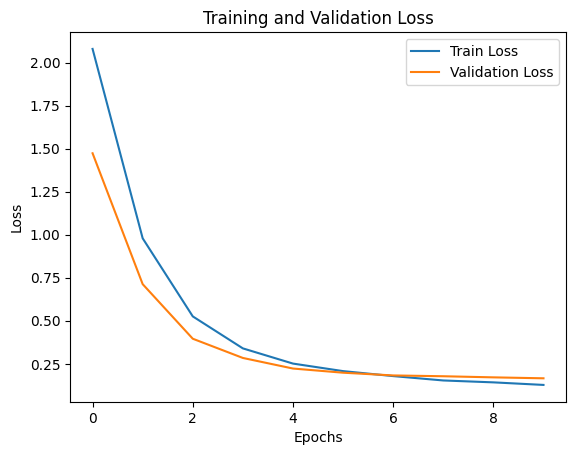

Model saved successfully at segnet_vgg16.pth


In [ ]:
print("Training SegNet with VGG16...\n")
model_vgg = SegNetVGG()
print(f"Total Trainable Parameters in VGG-based SegNet: {count_parameters(model_vgg):,}\n")
train_model(model_vgg, train_loader, val_loader)

model_path = "segnet_vgg16.pth"
torch.save(model_vgg.state_dict(), model_path)
print(f"Model saved successfully at {model_path}")

In [ ]:
test_loader = get_dataloader(type_of_data='test')
evaluate_model(model_vgg, test_loader, "cuda")

Using downloaded and verified file: ./data\VOCtrainval_11-May-2012.tar
Extracting ./data\VOCtrainval_11-May-2012.tar to ./data
Pixel Accuracy: 0.9473
Mean IoU: 0.9050
F1 Score: 0.9350
Dice Score: 0.5497


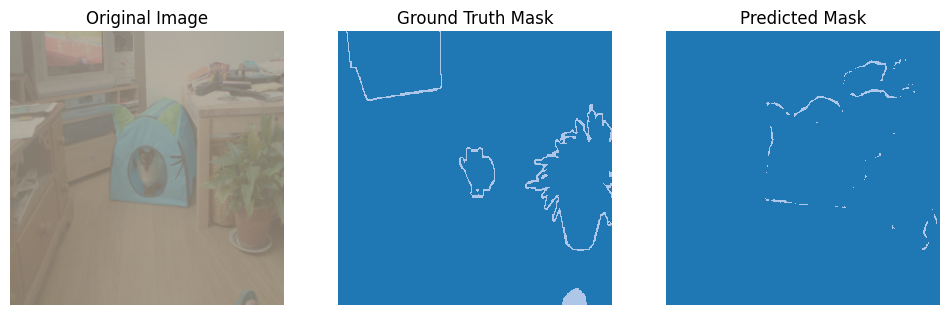

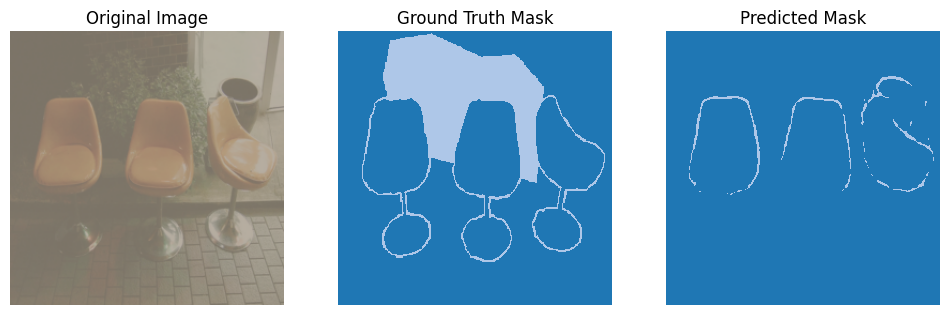

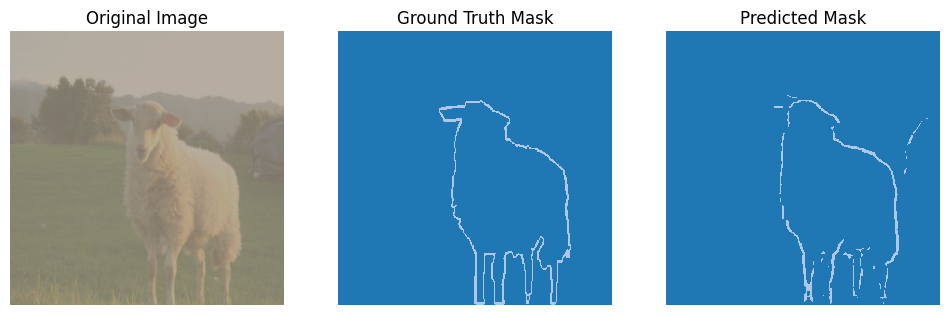

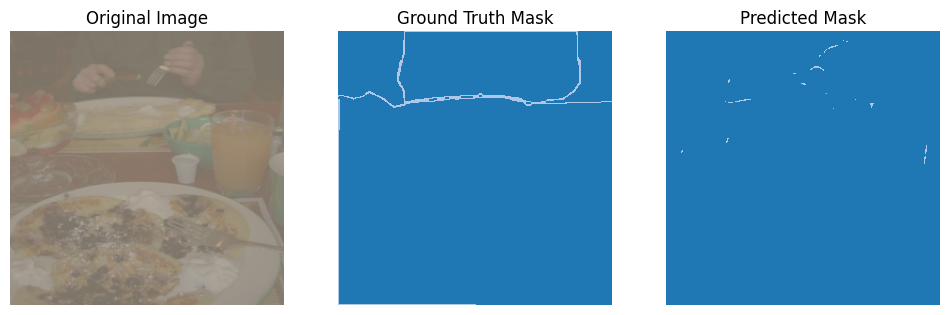

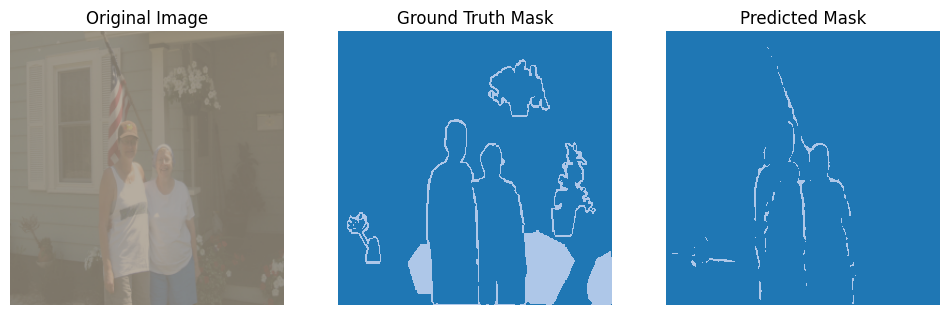

In [ ]:
visualize_predictions(model_vgg, test_loader, device="cuda", num_classes=21, num_samples=5)

Training SegNet with EfficientNet-B0...
Total Trainable Parameters in EfficientNet-based SegNet: 8,332,160


Epoch 1/10 [Validation]: 100%|█████████████████████████████████████████████████████████| 74/74 [00:06<00:00, 11.68it/s]


Epoch [1/10], Train Loss: 2.1096, Val Loss: 1.1708


Epoch 2/10 [Validation]: 100%|█████████████████████████████████████████████████████████| 74/74 [00:06<00:00, 11.06it/s]


Epoch [2/10], Train Loss: 0.7100, Val Loss: 0.4464


Epoch 3/10 [Validation]: 100%|█████████████████████████████████████████████████████████| 74/74 [00:06<00:00, 11.93it/s]


Epoch [3/10], Train Loss: 0.3534, Val Loss: 0.2877


Epoch 4/10 [Validation]: 100%|█████████████████████████████████████████████████████████| 74/74 [00:06<00:00, 12.05it/s]


Epoch [4/10], Train Loss: 0.2710, Val Loss: 0.2392


Epoch 5/10 [Validation]: 100%|█████████████████████████████████████████████████████████| 74/74 [00:06<00:00, 12.14it/s]


Epoch [5/10], Train Loss: 0.2354, Val Loss: 0.2112


Epoch 6/10 [Validation]: 100%|█████████████████████████████████████████████████████████| 74/74 [00:06<00:00, 10.57it/s]


Epoch [6/10], Train Loss: 0.2129, Val Loss: 0.1906


Epoch 7/10 [Validation]: 100%|█████████████████████████████████████████████████████████| 74/74 [00:06<00:00, 10.83it/s]


Epoch [7/10], Train Loss: 0.1982, Val Loss: 0.1827


Epoch 8/10 [Validation]: 100%|█████████████████████████████████████████████████████████| 74/74 [00:06<00:00, 11.29it/s]


Epoch [8/10], Train Loss: 0.1862, Val Loss: 0.1775


Epoch 9/10 [Validation]: 100%|█████████████████████████████████████████████████████████| 74/74 [00:06<00:00, 11.04it/s]


Epoch [9/10], Train Loss: 0.1732, Val Loss: 0.1707


Epoch 10/10 [Validation]: 100%|████████████████████████████████████████████████████████| 74/74 [00:06<00:00, 11.80it/s]


Epoch [10/10], Train Loss: 0.1624, Val Loss: 0.1696

Average Time per Epoch: 60.82 seconds



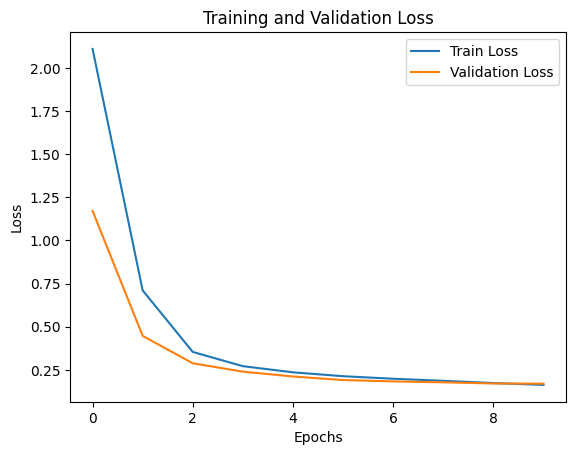

Model saved successfully at segnet_eff.pth


In [20]:
print("Training SegNet with EfficientNet-B0...")
model_eff = SegNetEfficientNet()
print(f"Total Trainable Parameters in EfficientNet-based SegNet: {count_parameters(model_eff):,}")
train_model(model_eff, train_loader, val_loader)

model_path = "segnet_eff.pth"
torch.save(model_eff.state_dict(), model_path)
print(f"Model saved successfully at {model_path}")

In [21]:
test_loader = get_dataloader(type_of_data='test')
evaluate_model(model_eff, test_loader, "cuda")

Using downloaded and verified file: ./data\VOCtrainval_11-May-2012.tar
Extracting ./data\VOCtrainval_11-May-2012.tar to ./data
Pixel Accuracy: 0.9439
Mean IoU: 0.8939
F1 Score: 0.9197
Dice Score: 0.5031


Performing Hyperparameter Tuning for SegNetVGG

Training with batch_size=4, lr=0.001
Using downloaded and verified file: ./data\VOCtrainval_11-May-2012.tar
Extracting ./data\VOCtrainval_11-May-2012.tar to ./data


Epoch 1/5 [Validation]: 100%|██████████████████████████████████████████████████████████| 74/74 [00:27<00:00,  2.70it/s]


Epoch [1/5], Train Loss: 2.0333, Val Loss: 1.3079


Epoch 2/5 [Validation]: 100%|██████████████████████████████████████████████████████████| 74/74 [00:20<00:00,  3.62it/s]


Epoch [2/5], Train Loss: 0.9586, Val Loss: 0.6789


Epoch 3/5 [Validation]: 100%|██████████████████████████████████████████████████████████| 74/74 [00:11<00:00,  6.44it/s]


Epoch [3/5], Train Loss: 0.5117, Val Loss: 0.3963


Epoch 4/5 [Validation]: 100%|██████████████████████████████████████████████████████████| 74/74 [00:11<00:00,  6.47it/s]


Epoch [4/5], Train Loss: 0.3284, Val Loss: 0.2902


Epoch 5/5 [Validation]: 100%|██████████████████████████████████████████████████████████| 74/74 [00:11<00:00,  6.57it/s]


Epoch [5/5], Train Loss: 0.2450, Val Loss: 0.2289

Average Time per Epoch: 185.53 seconds



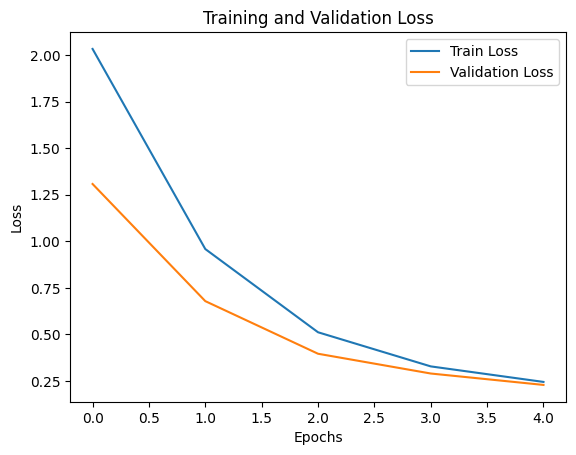

Training with batch_size=4, lr=0.0005
Using downloaded and verified file: ./data\VOCtrainval_11-May-2012.tar
Extracting ./data\VOCtrainval_11-May-2012.tar to ./data


Epoch 1/5 [Validation]: 100%|██████████████████████████████████████████████████████████| 74/74 [00:19<00:00,  3.83it/s]


Epoch [1/5], Train Loss: 1.8077, Val Loss: 1.2164


Epoch 2/5 [Validation]: 100%|██████████████████████████████████████████████████████████| 74/74 [00:11<00:00,  6.37it/s]


Epoch [2/5], Train Loss: 0.8644, Val Loss: 0.6379


Epoch 3/5 [Validation]: 100%|██████████████████████████████████████████████████████████| 74/74 [00:11<00:00,  6.50it/s]


Epoch [3/5], Train Loss: 0.4694, Val Loss: 0.3987


Epoch 4/5 [Validation]: 100%|██████████████████████████████████████████████████████████| 74/74 [00:11<00:00,  6.58it/s]


Epoch [4/5], Train Loss: 0.2992, Val Loss: 0.2765


Epoch 5/5 [Validation]: 100%|██████████████████████████████████████████████████████████| 74/74 [00:11<00:00,  6.44it/s]


Epoch [5/5], Train Loss: 0.2187, Val Loss: 0.2707

Average Time per Epoch: 123.83 seconds



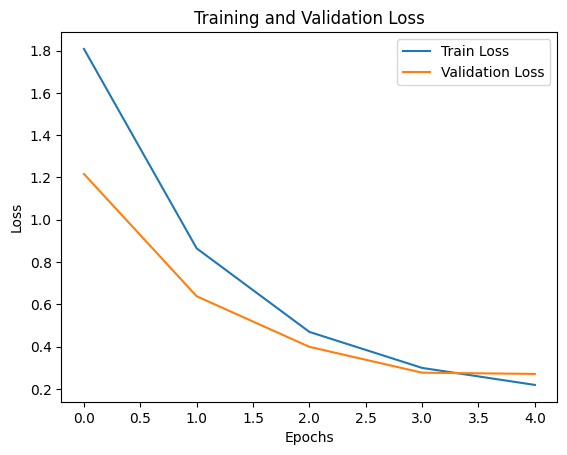

Training with batch_size=8, lr=0.001
Using downloaded and verified file: ./data\VOCtrainval_11-May-2012.tar
Extracting ./data\VOCtrainval_11-May-2012.tar to ./data


Epoch 1/5 [Validation]: 100%|██████████████████████████████████████████████████████████| 37/37 [00:19<00:00,  1.86it/s]


Epoch [1/5], Train Loss: 2.7215, Val Loss: 2.1847


Epoch 2/5 [Validation]: 100%|██████████████████████████████████████████████████████████| 37/37 [00:12<00:00,  3.02it/s]


Epoch [2/5], Train Loss: 1.7302, Val Loss: 1.4548


Epoch 3/5 [Validation]: 100%|██████████████████████████████████████████████████████████| 37/37 [00:12<00:00,  2.98it/s]


Epoch [3/5], Train Loss: 1.2223, Val Loss: 1.0477


Epoch 4/5 [Validation]: 100%|██████████████████████████████████████████████████████████| 37/37 [00:12<00:00,  2.99it/s]


Epoch [4/5], Train Loss: 0.8505, Val Loss: 0.7125


Epoch 5/5 [Validation]: 100%|██████████████████████████████████████████████████████████| 37/37 [00:12<00:00,  2.97it/s]


Epoch [5/5], Train Loss: 0.6006, Val Loss: 0.5459

Average Time per Epoch: 163.35 seconds



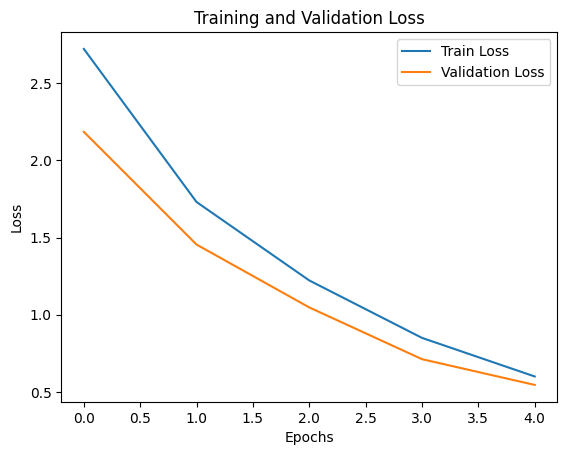

Training with batch_size=8, lr=0.0005
Using downloaded and verified file: ./data\VOCtrainval_11-May-2012.tar
Extracting ./data\VOCtrainval_11-May-2012.tar to ./data


Epoch 1/5 [Validation]: 100%|██████████████████████████████████████████████████████████| 37/37 [00:19<00:00,  1.86it/s]


Epoch [1/5], Train Loss: 2.7459, Val Loss: 2.1210


Epoch 2/5 [Validation]: 100%|██████████████████████████████████████████████████████████| 37/37 [00:12<00:00,  3.04it/s]


Epoch [2/5], Train Loss: 1.7481, Val Loss: 1.4373


Epoch 3/5 [Validation]: 100%|██████████████████████████████████████████████████████████| 37/37 [00:12<00:00,  3.02it/s]


Epoch [3/5], Train Loss: 1.2113, Val Loss: 0.9958


Epoch 4/5 [Validation]: 100%|██████████████████████████████████████████████████████████| 37/37 [00:12<00:00,  2.90it/s]


Epoch [4/5], Train Loss: 0.8330, Val Loss: 0.6998


Epoch 5/5 [Validation]: 100%|██████████████████████████████████████████████████████████| 37/37 [00:12<00:00,  3.01it/s]


Epoch [5/5], Train Loss: 0.5851, Val Loss: 0.5164

Average Time per Epoch: 163.36 seconds



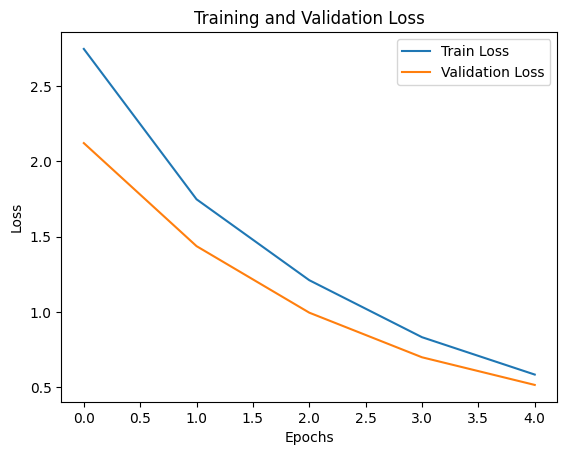

Best Hyperparameters: batch_size=4, lr=0.001


In [33]:
print("Performing Hyperparameter Tuning for SegNetVGG\n")
hyperparameter_tuning(Model = 'SegNetVGG')

Performing Hyperparameter Tuning for SegNetEfficientNetG

Training with batch_size=4, lr=0.001
Using downloaded and verified file: ./data\VOCtrainval_11-May-2012.tar
Extracting ./data\VOCtrainval_11-May-2012.tar to ./data


C:\Users\91883\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\91883\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/5 [Validation]: 100%|██████████████████████████████████████████████████████████| 74/74 [00:16<00:00,  4.60it/s]


Epoch [1/5], Train Loss: 2.0556, Val Loss: 1.1062


Epoch 2/5 [Validation]: 100%|██████████████████████████████████████████████████████████| 74/74 [00:06<00:00, 10.64it/s]


Epoch [2/5], Train Loss: 0.6708, Val Loss: 0.4322


Epoch 3/5 [Validation]: 100%|██████████████████████████████████████████████████████████| 74/74 [00:06<00:00, 11.44it/s]


Epoch [3/5], Train Loss: 0.3454, Val Loss: 0.2912


Epoch 4/5 [Validation]: 100%|██████████████████████████████████████████████████████████| 74/74 [00:06<00:00, 11.26it/s]


Epoch [4/5], Train Loss: 0.2650, Val Loss: 0.2434


Epoch 5/5 [Validation]: 100%|██████████████████████████████████████████████████████████| 74/74 [00:06<00:00, 10.99it/s]


Epoch [5/5], Train Loss: 0.2300, Val Loss: 0.2142

Average Time per Epoch: 60.87 seconds



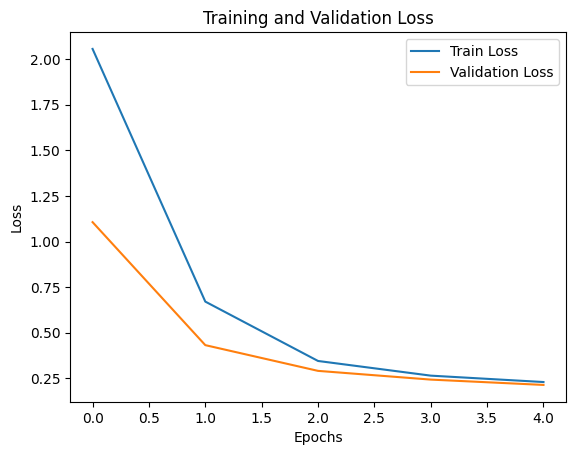

Training with batch_size=4, lr=0.0005
Using downloaded and verified file: ./data\VOCtrainval_11-May-2012.tar
Extracting ./data\VOCtrainval_11-May-2012.tar to ./data


Epoch 1/5 [Validation]: 100%|██████████████████████████████████████████████████████████| 74/74 [00:15<00:00,  4.66it/s]


Epoch [1/5], Train Loss: 2.0351, Val Loss: 1.1449


Epoch 2/5 [Validation]: 100%|██████████████████████████████████████████████████████████| 74/74 [00:06<00:00, 11.69it/s]


Epoch [2/5], Train Loss: 0.6637, Val Loss: 0.4305


Epoch 3/5 [Validation]: 100%|██████████████████████████████████████████████████████████| 74/74 [00:06<00:00, 12.00it/s]


Epoch [3/5], Train Loss: 0.3438, Val Loss: 0.2803


Epoch 4/5 [Validation]: 100%|██████████████████████████████████████████████████████████| 74/74 [00:06<00:00, 11.76it/s]


Epoch [4/5], Train Loss: 0.2644, Val Loss: 0.2306


Epoch 5/5 [Validation]: 100%|██████████████████████████████████████████████████████████| 74/74 [00:06<00:00, 11.58it/s]


Epoch [5/5], Train Loss: 0.2293, Val Loss: 0.2059

Average Time per Epoch: 59.32 seconds



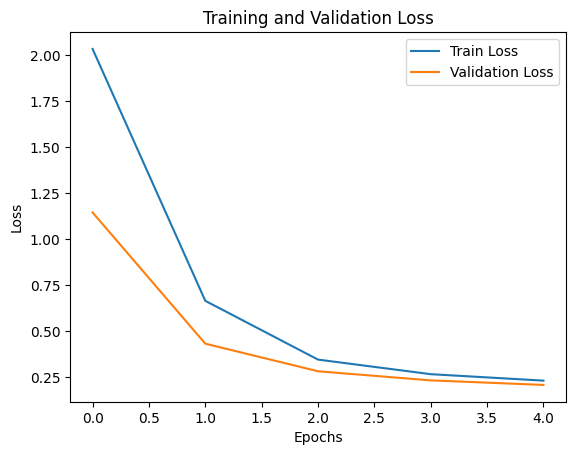

Training with batch_size=8, lr=0.001
Using downloaded and verified file: ./data\VOCtrainval_11-May-2012.tar
Extracting ./data\VOCtrainval_11-May-2012.tar to ./data


Epoch 1/5 [Validation]: 100%|██████████████████████████████████████████████████████████| 37/37 [00:13<00:00,  2.71it/s]


Epoch [1/5], Train Loss: 2.5633, Val Loss: 1.9963


Epoch 2/5 [Validation]: 100%|██████████████████████████████████████████████████████████| 37/37 [00:04<00:00,  8.14it/s]


Epoch [2/5], Train Loss: 1.5458, Val Loss: 1.1593


Epoch 3/5 [Validation]: 100%|██████████████████████████████████████████████████████████| 37/37 [00:05<00:00,  7.36it/s]


Epoch [3/5], Train Loss: 0.8169, Val Loss: 0.6324


Epoch 4/5 [Validation]: 100%|██████████████████████████████████████████████████████████| 37/37 [00:05<00:00,  7.25it/s]


Epoch [4/5], Train Loss: 0.5010, Val Loss: 0.4349


Epoch 5/5 [Validation]: 100%|██████████████████████████████████████████████████████████| 37/37 [00:04<00:00,  7.74it/s]


Epoch [5/5], Train Loss: 0.3700, Val Loss: 0.3242

Average Time per Epoch: 46.69 seconds



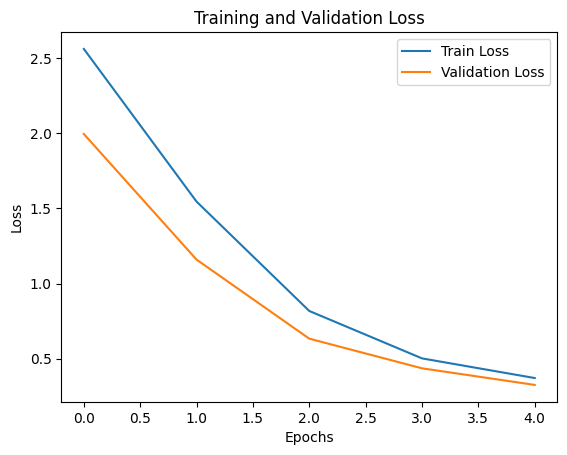

Training with batch_size=8, lr=0.0005
Using downloaded and verified file: ./data\VOCtrainval_11-May-2012.tar
Extracting ./data\VOCtrainval_11-May-2012.tar to ./data


Epoch 1/5 [Validation]: 100%|██████████████████████████████████████████████████████████| 37/37 [00:14<00:00,  2.61it/s]


Epoch [1/5], Train Loss: 2.6407, Val Loss: 2.0541


Epoch 2/5 [Validation]: 100%|██████████████████████████████████████████████████████████| 37/37 [00:05<00:00,  7.34it/s]


Epoch [2/5], Train Loss: 1.6154, Val Loss: 1.1684


Epoch 3/5 [Validation]: 100%|██████████████████████████████████████████████████████████| 37/37 [00:05<00:00,  7.10it/s]


Epoch [3/5], Train Loss: 0.8584, Val Loss: 0.6663


Epoch 4/5 [Validation]: 100%|██████████████████████████████████████████████████████████| 37/37 [00:04<00:00,  7.54it/s]


Epoch [4/5], Train Loss: 0.5213, Val Loss: 0.4550


Epoch 5/5 [Validation]: 100%|██████████████████████████████████████████████████████████| 37/37 [00:05<00:00,  7.32it/s]


Epoch [5/5], Train Loss: 0.3806, Val Loss: 0.3360

Average Time per Epoch: 47.98 seconds



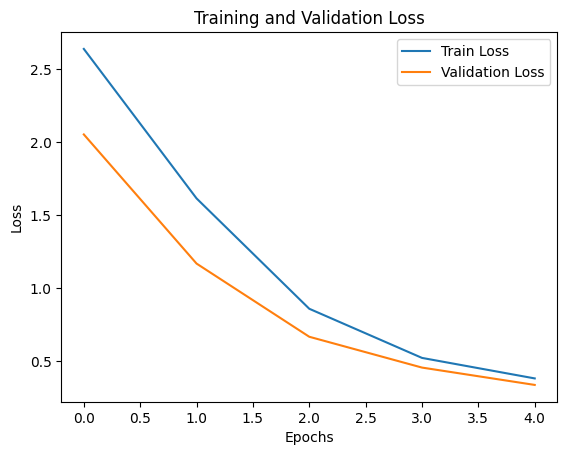

Best Hyperparameters: batch_size=4, lr=0.0005


In [34]:
print("Performing Hyperparameter Tuning for SegNetEfficientNetG\n")
hyperparameter_tuning(Model = 'SegNetEfficientNet')